/opt/anaconda3/envs/time2025/lib/python3.10/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


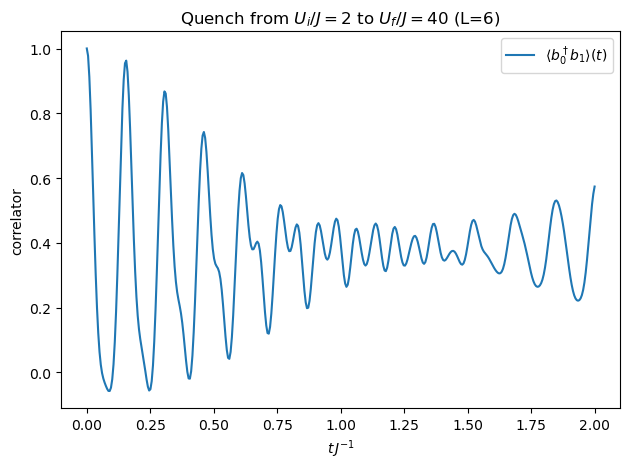

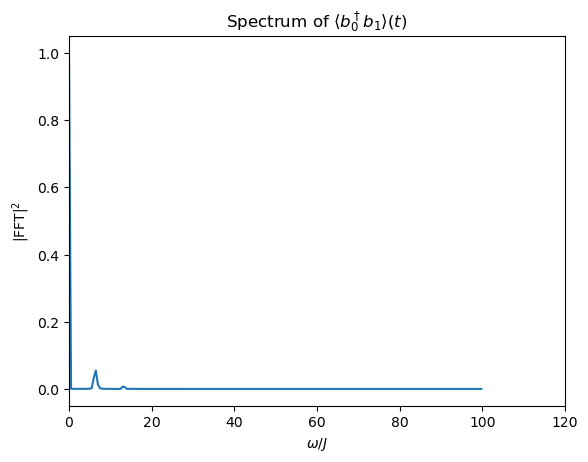

In [1]:
"""
QuTiP script for reproducing Fig. 1(a) of
Kollath, Laeuchli & Altman,
Phys. Rev. Lett. 98, 180601 (2007)

Took 10 mins to run on a Macbook Quad-Core Intel Core i7 i5 32 GB RAM.
"""

import numpy as np
import matplotlib.pyplot as plt
from qutip import destroy, qeye, tensor, qzero, expect, mesolve

# model parameters
L        = 6          # number of lattice sites (keep small for ED)
n_max    = 4          # local occupation cutoff  (0…n_max bosons per site)
J        = 1.0        # hopping amplitude sets the energy (time) scale
Ui       = 2.0 * J    # interaction before the quench
Uf       = 40.0 * J   # interaction after   the quench
t_max    = 2.0 / J    # run to t = 2 J^{-1}  (Fig. 1 shows up to ~2/J)
n_steps  = 400        # number of time points

# create Hamiltonian Function
def bh_hamiltonian(L, U, Jhop):
    """Return Bose‑Hubbard Hamiltonian for a chain of length L."""
    single_site_dim = n_max + 1
    b  = destroy(single_site_dim)
    n  = b.dag() * b
    ident = qeye(single_site_dim)

    H = qzero([single_site_dim]*L)
    # on‑site interaction
    for i in range(L):
        op_list = [ident]*L
        op_list[i] = n*(n-1)/2          #  U/2 n_i(n_i-1)
        H += U * tensor(op_list)

    # nearest‑neighbour hopping  –J Σ (b†_i b_{i+1}+h.c.)
    for i in range(L-1):
        # b†_i b_{i+1}
        op_list1 = [ident]*L
        op_list1[i]   = b.dag()
        op_list1[i+1] = b
        # b_i b†_{i+1}
        op_list2 = [ident]*L
        op_list2[i]   = b
        op_list2[i+1] = b.dag()
        H += -Jhop * (tensor(op_list1) + tensor(op_list2))
    return H

# build initial and final Hamiltonians
H_i = bh_hamiltonian(L, Ui, J)
H_f = bh_hamiltonian(L, Uf, J)

# initial ground state in the non-quenched Hamiltonian - can use sparse here
E0, psi0 = H_i.groundstate()

# -----------------------  time evolution after quench -----------------
tlist = np.linspace(0.0, t_max, n_steps)

# correlation operator b0† b1
b_site = destroy(n_max+1)
ident  = qeye(n_max+1)
op_b0d_b1 = tensor([b_site.dag(), b_site] + [ident]*(L-2))

result = mesolve(H_f, psi0, tlist, [], [op_b0d_b1])

corr_t = np.real(result.expect[0])   # expectation value vs time

# --------------------------  plot results -----------------------------
plt.figure()
plt.plot(tlist*J, corr_t, label=r'$\langle b_0^\dagger b_1\rangle(t)$')
plt.xlabel(r'$t\,J^{-1}$')
plt.ylabel(r'correlator')
plt.title('Quench from $U_i/J=2$ to $U_f/J=40$ (L=6)')
plt.legend()
plt.tight_layout()

# Fourier spectrum (optional inset)
freq  = np.fft.rfftfreq(n_steps, d=(tlist[1]-tlist[0]))
spec  = np.abs(np.fft.rfft(corr_t))**2
plt.figure()
plt.plot(freq/J, spec/spec.max())
plt.xlabel(r'$\omega/J$')
plt.ylabel(r'|FFT|$^2$')
plt.xlim(0, 120)   # Fig. 1 inset shows up to 120 J
plt.title('Spectrum of $\\langle b_0^\\dagger b_1\\rangle(t)$')

plt.show()